# TESS Atlas fit for TOI 1235

**Version: 'TEST'**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 1235.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/gh-pages/notebooks/'TEST'/toi-1235.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/gh-pages/notebooks/'TEST'/toi-1235.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/gh-pages/notebooks/'TEST'/toi-1235.ipynb).



## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3 dynesty isochrones

/bin/bash: pip: command not found


Then we'll set up the plotting styles and do all of the imports:

In [2]:
import os
import logging
import warnings
import multiprocessing as mp
import matplotlib.pyplot as plt
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
import corner
import astropy.units as u
from astroquery.mast import Catalogs
import pandas as pd
import functools

get_ipython().magic('config InlineBackend.figure_format = "retina"')

# TEMPORARY WORKAROUND
mp.set_start_method("fork")

# Don't use the schmantzy progress bar
os.environ["EXOPLANET_NO_AUTO_PBAR"] = "true"

# Warning
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Logging setup
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)
logger = logging.getLogger("exoplanet")
logger.setLevel(logging.DEBUG)

# matplotlib settings
plt.style.use("default")
plt.rcParams["savefig.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Liberation Sans"]
plt.rcParams["font.cursive"] = ["Liberation Sans"]
plt.rcParams["mathtext.fontset"] = "custom"

# Constants
TOI_DATASOURCE = "https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv"

In [3]:
TOI_NUMBER = 1235
__version__ = 'TEST'

## Fitting stellar parameters

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [4]:
def get_toi_data_from_database(toi_number):
    # Get the table of TOI info from ExoFOP
    tois = pd.read_csv(TOI_DATASOURCE)

    # Select all of the rows in the TOI table that are associated with this target
    toi = tois[tois["TOI"] == toi_number + 0.01].iloc[0]
    tic = toi['TIC ID']
    tois = tois[tois["TIC ID"] == tic].sort_values("TOI")
    return tois



class TOI:
    """TOI object to hold information about tois"""
    def __init__(self, toi_number):
        self.toi_number = toi_number

    @property
    def toi_number(self):
        return self.__toi_number

    @toi_number.setter
    def toi_number(self, value):
        self.__toi_number = value
        self.__toi_data = get_toi_data_from_database(value)

    @property
    def tic(self):
        return self.__toi_data['TIC ID'].iloc[0]

    @property
    def periods(self):
        """Planet periods"""
        periods = np.array(self.__toi_data["Period (days)"], dtype=float)
        assert np.all(periods > 0), "We haven't implemented single transits yet"
        return periods

    @property
    def t0s(self):
        """Phase (converted from BJD to TBJD)"""
        return np.array(self.__toi_data["Epoch (BJD)"], dtype=float) - 2457000

    @property
    def depths(self):
        """Depth to parts per thousand (from parts per million)"""
        return 1e-3 * np.array(self.__toi_data["Depth (ppm)"], dtype=float)

    @property
    def duration(self):
        """Duration in days (from hours)"""
        return np.array(tois["Duration (hours)"], dtype=float) / 24.0

    @property
    def letters(self):
        """Letters to identify each candidate"""
        return "bcdefghijklmnopqrstuvwxyz"[:len(self.periods)]

    def setup_outdir(self, version):
        output_dir = os.path.join("results", version, f"{self.toi_number}")
        os.makedirs(output_dir, exist_ok=True)
        self.outdir = output_dir

In [5]:
toi = TOI(toi_number=TOI_NUMBER)

First, let's download the TESS light curve using [lightkurve](https://docs.lightkurve.org/):

In [6]:
class TicLightcurve:
    """Object to hold lightcurve information of a Tic"""
    def __init__(self, tic):
        """
        Sets up a lightcurve object given the tic, with attributes
        time [days]
        flux [the relative flux in ppt]

        Args:
            tic: int, tic id of a TOI
        """
        self.tic = tic
        self.__lc = self.get_lightcurve()
        self.time = np.ascontiguousarray(self.__lc.time, dtype=np.float64)
        self.flux = np.ascontiguousarray(1e3 * (self.__lc.flux - 1), dtype=np.float64)
        self.flux_err = np.ascontiguousarray(1e3 * self.__lc.flux_err, dtype=np.float64)

    def get_lightcurve(self):
        lcfs = lk.search_lightcurvefile(
            f"TIC {self.tic}",
            mission="TESS"
        ).download_all()
        lc = lcfs.PDCSAP_FLUX.stitch()
        lc = lc.remove_nans().remove_outliers()
        return lc

    @property
    @functools.lru_cache()
    def period(self):
        """period of a time series using box least squares"""
        return xo.estimators.bls_estimator(
            self.time,
            self.flux,
            self.flux_err,
            min_period=2,
            max_period=20
        )

    @property
    def period_guess(self):
        return self.period["peak_info"]["period"]

    @property
    def t0_guess(self):
        return self.period["peak_info"]["transit_time"]

    @property
    def depth_guess(self):
        return self.period["peak_info"]["depth"]

    def mask_lightcurve(self, days:float):
        """Mask lightcurce data to look only at the central "days" duration of data """
        transit_mask = (
            np.abs((self.time - self.t0_guess + 0.5 * self.period_guess) % self.period_guess - 0.5 * self.period_guess)
            < days
        )
        self.time = np.ascontiguousarray(self.time[transit_mask])
        self.flux = np.ascontiguousarray(self.flux[transit_mask])
        self.flux_err = np.ascontiguousarray(self.flux_err[transit_mask])



def plot_lightcurve(lc:TicLightcurve):
    plt.plot(lc.time, lc.flux, "k", linewidth=0.5)
    plt.xlabel("time [days]")
    plt.ylabel("relative flux [ppt]");

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


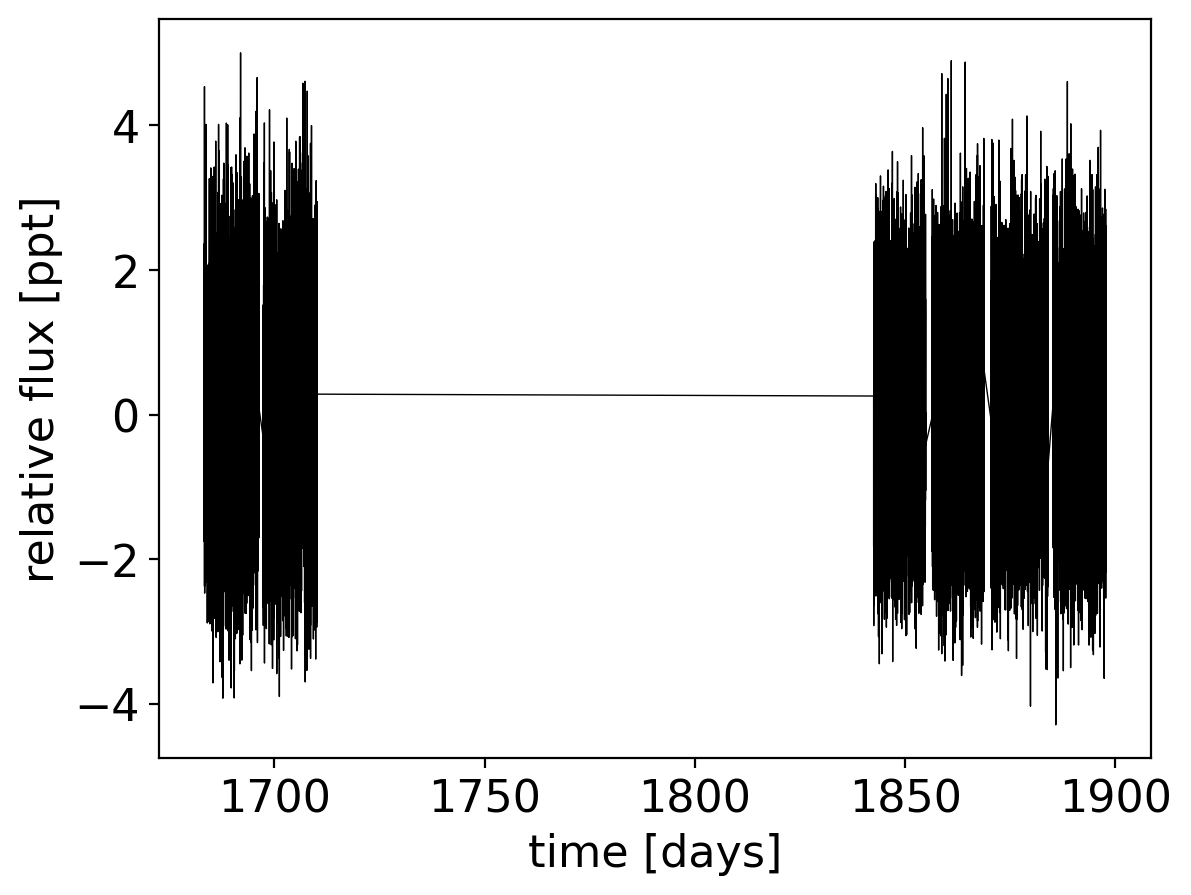

In [7]:
lc = TicLightcurve(tic=toi.tic)
plot_lightcurve(lc)

Then, find the period, phase and depth of the transit using box least squares:

In [8]:
def plot_lightcurve_power_vs_period(lc:TicLightcurve):
    plt.plot(lc.period["bls"].period, lc.period["bls"].power, "k", linewidth=0.5)
    plt.axvline(lc.period_guess, alpha=0.3, linewidth=5)
    plt.xlabel("period [days]")
    plt.ylabel("bls power")
    plt.yticks([])
    plt.xlim(lc.period["bls"].period.min(), lc.period["bls"].period.max());


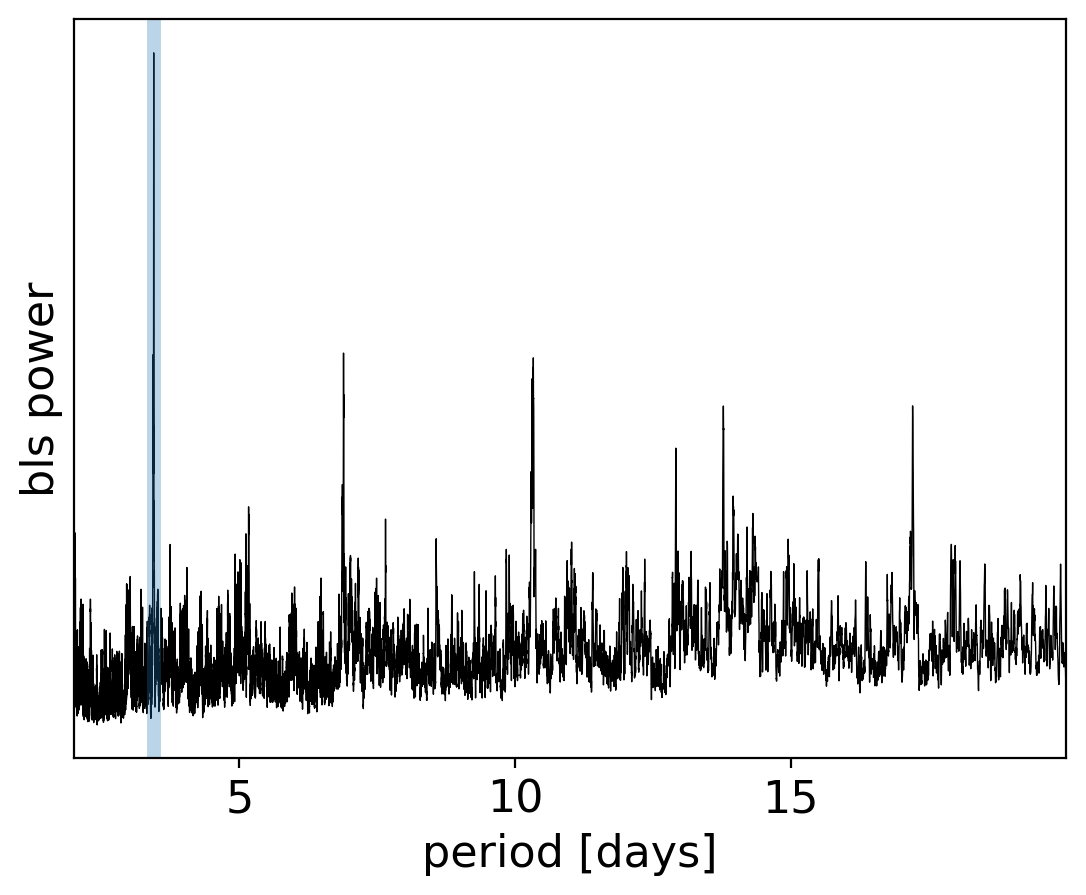

In [9]:
plot_lightcurve_power_vs_period(lc)

Then, for efficiency purposes, let's extract just the data within 0.25 days of the transits:

In [10]:
def plot_masked_lightcurve_flux_vs_time_since_transit(lc:TicLightcurve, days:float):
    time_fold = (lc.time - lc.t0_guess + 0.5 * lc.period_guess) % lc.period_guess - 0.5 * lc.period_guess
    plt.figure(figsize=(8, 4))
    plt.scatter(time_fold, lc.flux, c=lc.time, s=3)
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux [ppt]")
    plt.colorbar(label="time [days]")
    plt.xlim(-days, days);

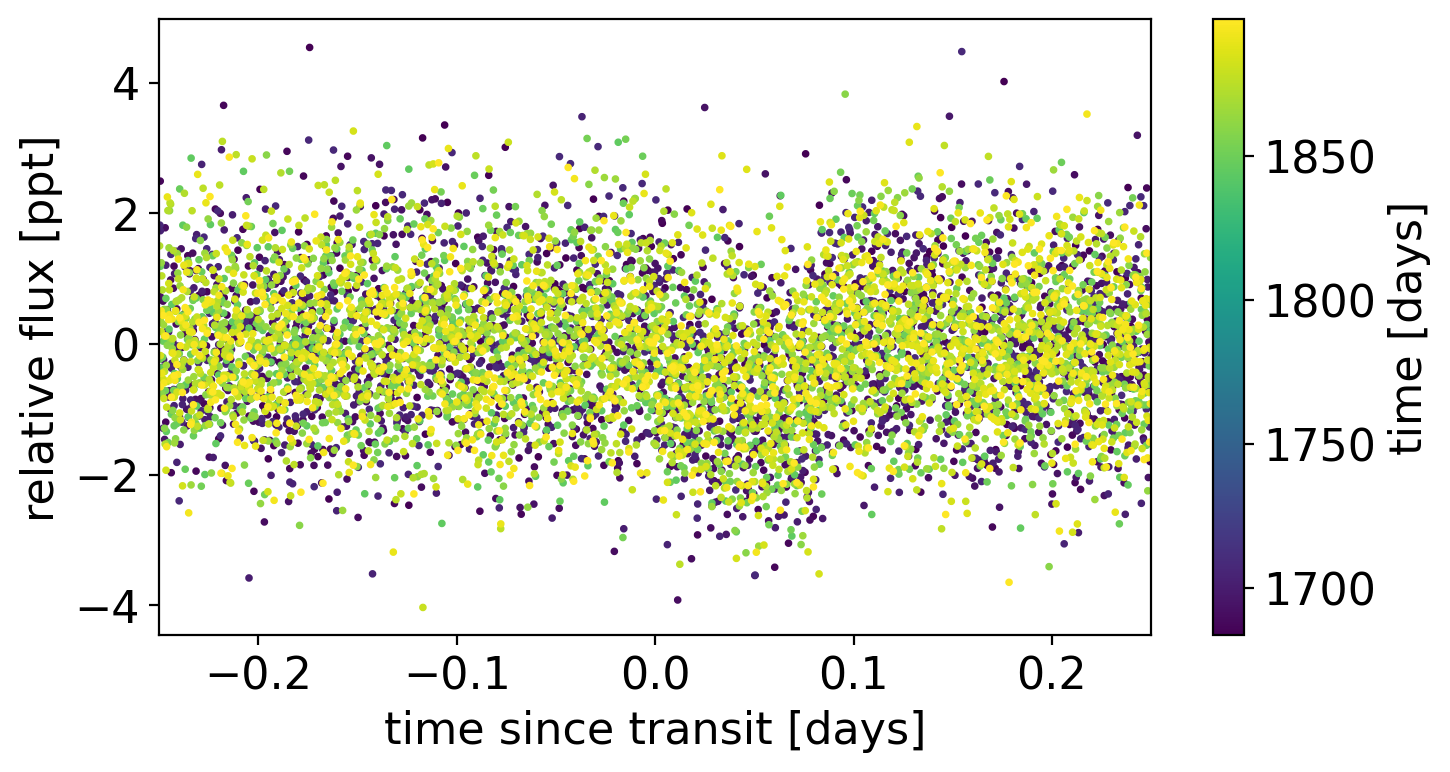

In [11]:
days = 0.25
lc.mask_lightcurve(days)
plot_masked_lightcurve_flux_vs_time_since_transit(lc, days)


That looks a little janky, but it's good enough for now.

## The probabilistic model

Here's how we set up the PyMC3 model in this case:

In [12]:
def build_model():
    with pm.Model() as toi_model:
        # Stellar parameters
        mean = pm.Normal("mean", mu=0.0, sigma=10.0)
        u = xo.distributions.QuadLimbDark("u")
        star_params = [mean, u]

        # Gaussian process noise model priors
        sigma = pm.InverseGamma("sigma", alpha=3.0, beta=2 * np.median(lc.flux_err))
        log_Sw4 = pm.Normal("log_Sw4", mu=0.0, sigma=10.0)
        log_w0 = pm.Normal("log_w0", mu=np.log(2 * np.pi / 10.0), sigma=10.0)
        kernel = xo.gp.terms.SHOTerm(log_Sw4=log_Sw4, log_w0=log_w0, Q=1.0 / 3)
        noise_params = [sigma, log_Sw4, log_w0]

        # Planet parameters priors
        log_ror = pm.Normal("log_ror", mu=0.5 * np.log(lc.depth_guess * 1e-3), sigma=10.0)
        ror = pm.Deterministic("ror", tt.exp(log_ror))

        # Orbital parameters priors
        log_period = pm.Normal("log_period", mu=np.log(lc.period_guess), sigma=1.0)
        t0 = pm.Normal("t0", mu=lc.t0_guess, sigma=1.0)
        log_dur = pm.Normal("log_dur", mu=np.log(0.1), sigma=10.0)
        b = xo.distributions.ImpactParameter("b", ror=ror)

        period = pm.Deterministic("period", tt.exp(log_period))
        dur = pm.Deterministic("dur", tt.exp(log_dur))

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(period=period, duration=dur, t0=t0, b=b)

        # We're going to track the implied density for reasons that will become clear later
        pm.Deterministic("rho_circ", orbit.rho_star) # rho circ is part of the model

        # Set up the mean transit model
        star = xo.LimbDarkLightCurve(u)

        def lc_model(t):
            return mean + 1e3 * tt.sum(
                star.get_light_curve(orbit=orbit, r=ror, t=t), axis=-1
            )

        # Finally the GP observation model
        gp = xo.gp.GP(kernel, lc.time, lc.flux_err ** 2 + sigma ** 2, mean=lc_model)
        gp.marginal("obs", observed=lc.flux) # compute likelihood (observed == data)

        # Double check that everything looks good - we shouldn't see any NaNs!
        print(toi_model.check_test_point())
        
        # cache params 
        params = dict(
            sigma=sigma,
            log_ror=log_ror,
            b=b,
            log_dur=log_dur,
            noise_params = noise_params,
            star_params=star_params
        )

        return toi_model, params, lc_model, gp
            
            
def optimize_model(model, sigma, log_ror, b, log_dur, noise_params, star_params):
    with model:         
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, [sigma])
        map_soln = xo.optimize(map_soln, [log_ror, b, log_dur])
        map_soln = xo.optimize(map_soln, noise_params)
        map_soln = xo.optimize(map_soln, star_params)
        map_soln = xo.optimize(map_soln)
        return map_soln

In [13]:
toi_model, params, lc_model, gp = build_model()
map_soln = optimize_model(toi_model, **params)

mean                   -3.22
u_quadlimbdark__       -2.77
sigma_log__            -0.53
log_Sw4                -3.22
log_w0                 -3.22
log_ror                -3.22
log_period             -0.92
t0                     -0.92
log_dur                -3.22
b_impact__             -1.39
obs                -11393.28
Name: Log-probability of test_point, dtype: float64


optimizing logp for variables: [sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.141591e+04]

1it [00:00, 138.49it/s, logp=-1.141591e+04]

2it [00:00, 192.60it/s, logp=-1.127282e+04]

3it [00:00, 218.59it/s, logp=-1.127148e+04]

4it [00:00, 235.97it/s, logp=-1.126947e+04]

5it [00:00, 247.84it/s, logp=-1.126867e+04]

6it [00:00, 255.78it/s, logp=-1.126862e+04]

7it [00:00, 262.47it/s, logp=-1.126862e+04]

8it [00:00, 265.55it/s, logp=-1.126862e+04]

9it [00:00, 271.29it/s, logp=-1.126862e+04]

10it [00:00, 10.75it/s, logp=-1.126862e+04]


message: Optimization terminated successfully.
logp: -11415.914497678874 -> -11268.62342407732


optimizing logp for variables: [log_dur, b, log_ror]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.126862e+04]

1it [00:00, 140.45it/s, logp=-1.126862e+04]

2it [00:00, 175.55it/s, logp=-1.125683e+04]

3it [00:00, 175.80it/s, logp=-1.129858e+04]

4it [00:00, 184.92it/s, logp=-1.126709e+04]

5it [00:00, 196.03it/s, logp=-1.125652e+04]

6it [00:00, 204.48it/s, logp=-1.125590e+04]

7it [00:00, 213.19it/s, logp=-1.125328e+04]

8it [00:00, 220.16it/s, logp=-1.124555e+04]

9it [00:00, 226.61it/s, logp=-1.125936e+04]

10it [00:00, 231.84it/s, logp=-1.123327e+04]

11it [00:00, 237.67it/s, logp=-1.127379e+04]

12it [00:00, 242.41it/s, logp=-1.122894e+04]

13it [00:00, 245.35it/s, logp=-1.122305e+04]

14it [00:00, 247.27it/s, logp=-1.122884e+04]

15it [00:00, 251.83it/s, logp=-1.122282e+04]

16it [00:00, 254.36it/s, logp=-1.122227e+04]

17it [00:00, 257.21it/s, logp=-1.122160e+04]

18it [00:00, 259.57it/s, logp=-1.122113e+04]

19it [00:00, 261.49it/s, logp=-1.122049e+04]

20it [00:00, 267.19it/s, logp=-1.128426e+04]

21it [00:00, 270.46it/s, logp=-1.122049e+04]

22it [00:00, 272.20it/s, logp=-1.122023e+04]

23it [00:00, 274.55it/s, logp=-1.122015e+04]

24it [00:00, 276.62it/s, logp=-1.122294e+04]

25it [00:00, 279.08it/s, logp=-1.122011e+04]

26it [00:00, 280.08it/s, logp=-1.122006e+04]

27it [00:00, 281.20it/s, logp=-1.121998e+04]

28it [00:00, 282.77it/s, logp=-1.121989e+04]

29it [00:00, 284.67it/s, logp=-1.121984e+04]

30it [00:00, 292.39it/s, logp=-1.121984e+04]

30it [00:00, 292.39it/s, logp=-1.121982e+04]

31it [00:00, 292.39it/s, logp=-1.121981e+04]

32it [00:00, 292.39it/s, logp=-1.121981e+04]

33it [00:00, 292.39it/s, logp=-1.121981e+04]

34it [00:00, 292.39it/s, logp=-1.121981e+04]

35it [00:00, 292.39it/s, logp=-1.121981e+04]

36it [00:00, 292.39it/s, logp=-1.121981e+04]

37it [00:00, 292.39it/s, logp=-1.121981e+04]

38it [00:00, 292.39it/s, logp=-1.121981e+04]

39it [00:00, 292.39it/s, logp=-1.121981e+04]

40it [00:00, 292.39it/s, logp=-1.121981e+04]

41it [00:00, 292.39it/s, logp=-1.121981e+04]

42it [00:00, 292.39it/s, logp=-1.121981e+04]

43it [00:00, 292.39it/s, logp=-1.121981e+04]

44it [00:00, 292.39it/s, logp=-1.121981e+04]

45it [00:00, 292.39it/s, logp=-1.121981e+04]

46it [00:00, 292.39it/s, logp=-1.121981e+04]

47it [00:00, 292.39it/s, logp=-1.121981e+04]

48it [00:00, 292.39it/s, logp=-1.121981e+04]

49it [00:00, 292.39it/s, logp=-1.121981e+04]

50it [00:00, 292.39it/s, logp=-1.121981e+04]

51it [00:00, 292.39it/s, logp=-1.121981e+04]

52it [00:00, 292.39it/s, logp=-1.121981e+04]

53it [00:00, 292.39it/s, logp=-1.121981e+04]

54it [00:00, 292.39it/s, logp=-1.121981e+04]

55it [00:00, 292.39it/s, logp=-1.121981e+04]

56it [00:00, 292.39it/s, logp=-1.121981e+04]

57it [00:00, 292.39it/s, logp=-1.121981e+04]

58it [00:00, 292.39it/s, logp=-1.121981e+04]

59it [00:00, 292.39it/s, logp=-1.121981e+04]

60it [00:00, 292.39it/s, logp=-1.121981e+04]

61it [00:00, 292.39it/s, logp=-1.121981e+04]

62it [00:00, 292.39it/s, logp=-1.121981e+04]

63it [00:00, 302.09it/s, logp=-1.121981e+04]

63it [00:00, 302.09it/s, logp=-1.121981e+04]

64it [00:00, 302.09it/s, logp=-1.121981e+04]

65it [00:00, 302.09it/s, logp=-1.121981e+04]

66it [00:00, 302.09it/s, logp=-1.121981e+04]

67it [00:00, 302.09it/s, logp=-1.121981e+04]

68it [00:00, 302.09it/s, logp=-1.121981e+04]

69it [00:00, 302.09it/s, logp=-1.121981e+04]

70it [00:00, 302.09it/s, logp=-1.121981e+04]

71it [00:00, 302.09it/s, logp=-1.121981e+04]

72it [00:00, 302.09it/s, logp=-1.121981e+04]

73it [00:00, 302.09it/s, logp=-1.121981e+04]

74it [00:00, 302.09it/s, logp=-1.121981e+04]

75it [00:00, 302.09it/s, logp=-1.121981e+04]

76it [00:00, 302.09it/s, logp=-1.121981e+04]

77it [00:00, 302.09it/s, logp=-1.121981e+04]

78it [00:00, 302.09it/s, logp=-1.121981e+04]

79it [00:00, 302.09it/s, logp=-1.121981e+04]

80it [00:00, 302.09it/s, logp=-1.121981e+04]

81it [00:00, 302.09it/s, logp=-1.121981e+04]

82it [00:00, 302.09it/s, logp=-1.121981e+04]

83it [00:00, 302.09it/s, logp=-1.121981e+04]

84it [00:00, 302.09it/s, logp=-1.121981e+04]

85it [00:00, 302.09it/s, logp=-1.121981e+04]

86it [00:00, 302.09it/s, logp=-1.121981e+04]

87it [00:00, 302.09it/s, logp=-1.121981e+04]

88it [00:00, 302.09it/s, logp=-1.121981e+04]

89it [00:00, 302.09it/s, logp=-1.121981e+04]

90it [00:00, 302.09it/s, logp=-1.121981e+04]

91it [00:00, 302.09it/s, logp=-1.121981e+04]

92it [00:00, 302.09it/s, logp=-1.121981e+04]

93it [00:00, 299.01it/s, logp=-1.121981e+04]

93it [00:00, 299.01it/s, logp=-1.121981e+04]

94it [00:00, 299.01it/s, logp=-1.121981e+04]

95it [00:00, 299.01it/s, logp=-1.121981e+04]

96it [00:00, 299.01it/s, logp=-1.121981e+04]

97it [00:00, 299.01it/s, logp=-1.121981e+04]

98it [00:00, 299.01it/s, logp=-1.121981e+04]

99it [00:00, 299.01it/s, logp=-1.121981e+04]

100it [00:00, 299.01it/s, logp=-1.121981e+04]

101it [00:00, 240.63it/s, logp=-1.121981e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: -11268.62342407732 -> -11219.805300798156


optimizing logp for variables: [log_w0, log_Sw4, sigma]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.121981e+04]

1it [00:00, 119.20it/s, logp=-1.121981e+04]

2it [00:00, 159.10it/s, logp=-1.119425e+04]

3it [00:00, 180.81it/s, logp=-1.260434e+04]

4it [00:00, 194.52it/s, logp=-1.119983e+04]

5it [00:00, 203.45it/s, logp=-1.119334e+04]

6it [00:00, 208.11it/s, logp=-1.119216e+04]

7it [00:00, 213.98it/s, logp=-1.119018e+04]

8it [00:00, 220.46it/s, logp=-1.118466e+04]

9it [00:00, 223.35it/s, logp=-1.119637e+04]

10it [00:00, 226.04it/s, logp=-1.118113e+04]

11it [00:00, 227.79it/s, logp=-1.117475e+04]

12it [00:00, 226.12it/s, logp=-1.116636e+04]

13it [00:00, 227.10it/s, logp=-1.116434e+04]

14it [00:00, 229.03it/s, logp=-1.116427e+04]

15it [00:00, 230.32it/s, logp=-1.116425e+04]

16it [00:00, 231.56it/s, logp=-1.116425e+04]

17it [00:00, 233.28it/s, logp=-1.116425e+04]

18it [00:00, 234.73it/s, logp=-1.116425e+04]

19it [00:00, 236.28it/s, logp=-1.116425e+04]

20it [00:00, 237.93it/s, logp=-1.116425e+04]

21it [00:00, 239.68it/s, logp=-1.116425e+04]

22it [00:00, 241.55it/s, logp=-1.116425e+04]

23it [00:00, 243.05it/s, logp=-1.116425e+04]

24it [00:00, 244.77it/s, logp=-1.116425e+04]

25it [00:00, 246.35it/s, logp=-1.116425e+04]

26it [00:00, 254.83it/s, logp=-1.116425e+04]

26it [00:00, 254.83it/s, logp=-1.116425e+04]

27it [00:00, 254.83it/s, logp=-1.116425e+04]

28it [00:00, 254.83it/s, logp=-1.116425e+04]

29it [00:00, 254.83it/s, logp=-1.116425e+04]

30it [00:00, 254.83it/s, logp=-1.116425e+04]

31it [00:00, 254.83it/s, logp=-1.116425e+04]

32it [00:00, 254.83it/s, logp=-1.116425e+04]

33it [00:00, 254.83it/s, logp=-1.116425e+04]

34it [00:00, 254.83it/s, logp=-1.116425e+04]

35it [00:00, 254.83it/s, logp=-1.116425e+04]

36it [00:00, 254.83it/s, logp=-1.116425e+04]

37it [00:00, 254.83it/s, logp=-1.116425e+04]

38it [00:00, 254.83it/s, logp=-1.116425e+04]

39it [00:00, 254.83it/s, logp=-1.116425e+04]

40it [00:00, 254.83it/s, logp=-1.116425e+04]

41it [00:00, 254.83it/s, logp=-1.116425e+04]

42it [00:00, 254.83it/s, logp=-1.116425e+04]

43it [00:00, 254.83it/s, logp=-1.116425e+04]

44it [00:00, 254.83it/s, logp=-1.116425e+04]

45it [00:00, 254.83it/s, logp=-1.116425e+04]

46it [00:00, 254.83it/s, logp=-1.116425e+04]

47it [00:00, 254.83it/s, logp=-1.116425e+04]

48it [00:00, 254.83it/s, logp=-1.116425e+04]

49it [00:00, 254.83it/s, logp=-1.116425e+04]

50it [00:00, 254.83it/s, logp=-1.116425e+04]

51it [00:00, 170.63it/s, logp=-1.116425e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: -11219.805300798156 -> -11164.253211863565


optimizing logp for variables: [u, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.116425e+04]

1it [00:00, 145.80it/s, logp=-1.116425e+04]

2it [00:00, 193.22it/s, logp=-1.171399e+04]

3it [00:00, 222.34it/s, logp=-1.116408e+04]

4it [00:00, 236.96it/s, logp=-1.116373e+04]

5it [00:00, 249.86it/s, logp=-1.116256e+04]

6it [00:00, 254.71it/s, logp=-1.116103e+04]

7it [00:00, 256.01it/s, logp=-1.116101e+04]

8it [00:00, 260.08it/s, logp=-1.116101e+04]

9it [00:00, 264.40it/s, logp=-1.116101e+04]

10it [00:00, 267.49it/s, logp=-1.116101e+04]

11it [00:00, 268.10it/s, logp=-1.116101e+04]

12it [00:00, 270.35it/s, logp=-1.116101e+04]

13it [00:00, 271.94it/s, logp=-1.116101e+04]

14it [00:00, 94.38it/s, logp=-1.116101e+04] 


message: Optimization terminated successfully.
logp: -11164.253211863565 -> -11161.008269565953


optimizing logp for variables: [b, log_dur, t0, log_period, log_ror, log_w0, log_Sw4, sigma, u, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.116101e+04]

1it [00:00, 125.58it/s, logp=-1.116101e+04]

2it [00:00, 176.44it/s, logp=-1.121043e+04]

3it [00:00, 205.14it/s, logp=-1.120777e+04]

4it [00:00, 222.23it/s, logp=-1.120489e+04]

5it [00:00, 231.18it/s, logp=-1.120919e+04]

6it [00:00, 240.49it/s, logp=-1.119759e+04]

7it [00:00, 244.35it/s, logp=-1.118727e+04]

8it [00:00, 243.68it/s, logp=-1.116110e+04]

9it [00:00, 247.33it/s, logp=-1.116101e+04]

10it [00:00, 245.48it/s, logp=-1.116100e+04]

11it [00:00, 246.47it/s, logp=-1.116098e+04]

12it [00:00, 247.03it/s, logp=-1.116090e+04]

13it [00:00, 247.10it/s, logp=-1.116070e+04]

14it [00:00, 247.27it/s, logp=-1.116001e+04]

15it [00:00, 246.95it/s, logp=-1.116517e+04]

16it [00:00, 246.99it/s, logp=-1.115986e+04]

17it [00:00, 247.12it/s, logp=-1.115983e+04]

18it [00:00, 246.60it/s, logp=-1.115977e+04]

19it [00:00, 246.39it/s, logp=-1.115967e+04]

20it [00:00, 246.90it/s, logp=-1.115933e+04]

21it [00:00, 246.73it/s, logp=-1.116346e+04]

22it [00:00, 246.24it/s, logp=-1.115929e+04]

23it [00:00, 245.70it/s, logp=-1.115920e+04]

24it [00:00, 245.50it/s, logp=-1.115904e+04]

25it [00:00, 246.89it/s, logp=-1.115881e+04]

26it [00:00, 255.18it/s, logp=-1.115881e+04]

26it [00:00, 255.18it/s, logp=-1.115858e+04]

27it [00:00, 255.18it/s, logp=-1.115849e+04]

28it [00:00, 255.18it/s, logp=-1.115843e+04]

29it [00:00, 255.18it/s, logp=-1.115861e+04]

30it [00:00, 255.18it/s, logp=-1.115838e+04]

31it [00:00, 255.18it/s, logp=-1.115910e+04]

32it [00:00, 255.18it/s, logp=-1.115836e+04]

33it [00:00, 255.18it/s, logp=-1.115835e+04]

34it [00:00, 255.18it/s, logp=-1.115834e+04]

35it [00:00, 255.18it/s, logp=-1.115834e+04]

36it [00:00, 255.18it/s, logp=-1.115834e+04]

37it [00:00, 255.18it/s, logp=-1.115834e+04]

38it [00:00, 255.18it/s, logp=-1.115834e+04]

39it [00:00, 255.18it/s, logp=-1.115834e+04]

40it [00:00, 255.18it/s, logp=-1.115834e+04]

41it [00:00, 255.18it/s, logp=-1.115834e+04]

42it [00:00, 255.18it/s, logp=-1.115834e+04]

43it [00:00, 255.18it/s, logp=-1.115834e+04]

44it [00:00, 255.18it/s, logp=-1.115834e+04]

45it [00:00, 255.18it/s, logp=-1.115834e+04]

46it [00:00, 255.18it/s, logp=-1.115834e+04]

47it [00:00, 255.18it/s, logp=-1.115834e+04]

48it [00:00, 255.18it/s, logp=-1.115834e+04]

49it [00:00, 255.18it/s, logp=-1.115834e+04]

50it [00:00, 255.18it/s, logp=-1.115834e+04]

51it [00:00, 255.18it/s, logp=-1.115834e+04]

52it [00:00, 255.93it/s, logp=-1.115834e+04]

52it [00:00, 255.93it/s, logp=-1.115834e+04]

53it [00:00, 255.93it/s, logp=-1.115834e+04]

54it [00:00, 255.93it/s, logp=-1.115834e+04]

55it [00:00, 255.93it/s, logp=-1.115834e+04]

56it [00:00, 255.93it/s, logp=-1.115834e+04]

57it [00:00, 255.93it/s, logp=-1.115834e+04]

58it [00:00, 255.93it/s, logp=-1.115834e+04]

59it [00:00, 255.93it/s, logp=-1.115834e+04]

60it [00:00, 255.93it/s, logp=-1.115834e+04]

61it [00:00, 255.93it/s, logp=-1.115834e+04]

62it [00:00, 255.93it/s, logp=-1.115834e+04]

63it [00:00, 255.93it/s, logp=-1.115834e+04]

64it [00:00, 255.93it/s, logp=-1.115834e+04]

65it [00:00, 255.93it/s, logp=-1.115834e+04]

66it [00:00, 255.93it/s, logp=-1.115834e+04]

67it [00:00, 255.93it/s, logp=-1.115834e+04]

68it [00:00, 255.93it/s, logp=-1.115834e+04]

69it [00:00, 255.93it/s, logp=-1.115834e+04]

70it [00:00, 255.93it/s, logp=-1.115834e+04]

71it [00:00, 255.93it/s, logp=-1.115834e+04]

72it [00:00, 255.93it/s, logp=-1.115834e+04]

73it [00:00, 255.93it/s, logp=-1.115834e+04]

74it [00:00, 255.93it/s, logp=-1.115834e+04]

75it [00:00, 255.93it/s, logp=-1.115834e+04]

76it [00:00, 255.93it/s, logp=-1.115834e+04]

77it [00:00, 255.93it/s, logp=-1.115834e+04]

78it [00:00, 254.11it/s, logp=-1.115834e+04]

78it [00:00, 254.11it/s, logp=-1.115834e+04]

79it [00:00, 254.11it/s, logp=-1.115834e+04]

80it [00:00, 254.11it/s, logp=-1.115834e+04]

81it [00:00, 254.11it/s, logp=-1.115834e+04]

82it [00:00, 254.11it/s, logp=-1.115834e+04]

83it [00:00, 254.11it/s, logp=-1.115834e+04]

84it [00:00, 254.11it/s, logp=-1.115834e+04]

85it [00:00, 254.11it/s, logp=-1.115834e+04]

86it [00:00, 254.11it/s, logp=-1.115834e+04]

87it [00:00, 254.11it/s, logp=-1.115834e+04]

88it [00:00, 254.11it/s, logp=-1.115834e+04]

89it [00:00, 254.11it/s, logp=-1.115834e+04]

90it [00:00, 254.11it/s, logp=-1.115834e+04]

91it [00:00, 254.11it/s, logp=-1.115834e+04]

92it [00:00, 254.11it/s, logp=-1.115834e+04]

93it [00:00, 254.11it/s, logp=-1.115834e+04]

94it [00:00, 254.11it/s, logp=-1.115834e+04]

95it [00:00, 254.11it/s, logp=-1.115834e+04]

96it [00:00, 254.11it/s, logp=-1.115834e+04]

97it [00:00, 254.11it/s, logp=-1.115834e+04]

98it [00:00, 254.11it/s, logp=-1.115834e+04]

99it [00:00, 254.11it/s, logp=-1.115834e+04]

100it [00:00, 254.11it/s, logp=-1.115834e+04]

101it [00:00, 254.11it/s, logp=-1.115834e+04]

102it [00:00, 254.11it/s, logp=-1.115834e+04]

103it [00:00, 254.11it/s, logp=-1.115834e+04]

104it [00:00, 254.11it/s, logp=-1.115834e+04]

105it [00:00, 254.11it/s, logp=-1.115834e+04]

106it [00:00, 259.40it/s, logp=-1.115834e+04]

106it [00:00, 259.40it/s, logp=-1.115834e+04]

107it [00:00, 259.40it/s, logp=-1.115834e+04]

108it [00:00, 259.40it/s, logp=-1.115834e+04]

109it [00:00, 259.40it/s, logp=-1.115834e+04]

110it [00:00, 259.40it/s, logp=-1.115834e+04]

111it [00:00, 259.40it/s, logp=-1.115834e+04]

112it [00:00, 259.40it/s, logp=-1.115834e+04]

113it [00:00, 259.40it/s, logp=-1.115834e+04]

114it [00:00, 259.40it/s, logp=-1.115834e+04]

115it [00:00, 259.40it/s, logp=-1.115834e+04]

116it [00:00, 259.40it/s, logp=-1.115834e+04]

117it [00:00, 259.40it/s, logp=-1.115834e+04]

118it [00:00, 259.40it/s, logp=-1.115834e+04]

119it [00:00, 259.40it/s, logp=-1.115834e+04]

120it [00:00, 259.40it/s, logp=-1.115834e+04]

121it [00:00, 259.40it/s, logp=-1.115834e+04]

122it [00:00, 259.40it/s, logp=-1.115834e+04]

123it [00:00, 259.40it/s, logp=-1.115834e+04]

124it [00:00, 259.40it/s, logp=-1.115834e+04]

125it [00:00, 259.40it/s, logp=-1.115834e+04]

126it [00:00, 259.40it/s, logp=-1.115834e+04]

127it [00:00, 259.40it/s, logp=-1.115834e+04]

128it [00:00, 259.40it/s, logp=-1.115834e+04]

129it [00:00, 259.40it/s, logp=-1.115834e+04]

130it [00:00, 259.40it/s, logp=-1.115834e+04]

131it [00:00, 259.40it/s, logp=-1.115834e+04]

132it [00:00, 258.26it/s, logp=-1.115834e+04]

132it [00:00, 258.26it/s, logp=-1.115834e+04]

133it [00:00, 258.26it/s, logp=-1.115834e+04]

134it [00:00, 258.26it/s, logp=-1.115834e+04]

135it [00:00, 218.37it/s, logp=-1.115834e+04]


message: Desired error not necessarily achieved due to precision loss.
logp: -11161.008269565953 -> -11158.344544315016


Now we can plot our initial model:

In [14]:
def plot_model(lc, toi_model, map_soln, gp_pred, lc_pred):
    plt.figure(figsize=(8, 4))
    time_fold = (lc.time - map_soln["t0"] + 0.5 * map_soln["period"]) % map_soln[
        "period"
    ] - 0.5 * map_soln["period"]
    inds = np.argsort(time_fold)
    plt.scatter(time_fold, lc.flux - gp_pred - map_soln["mean"], c=lc.time, s=3)
    plt.plot(time_fold[inds], lc_pred[inds] - map_soln["mean"], "k")
    plt.xlabel("time since transit [days]")
    plt.ylabel("relative flux [ppt]")
    plt.colorbar(label="time [days]")
    plt.xlim(-days, days);
    
    
def obtain_prediction(model, gp, lc_model, map_soln):
    with model:
        gp_pred, lc_pred = xo.eval_in_model([gp.predict(), lc_model(lc.time)], map_soln)
        return gp_pred, lc_pred

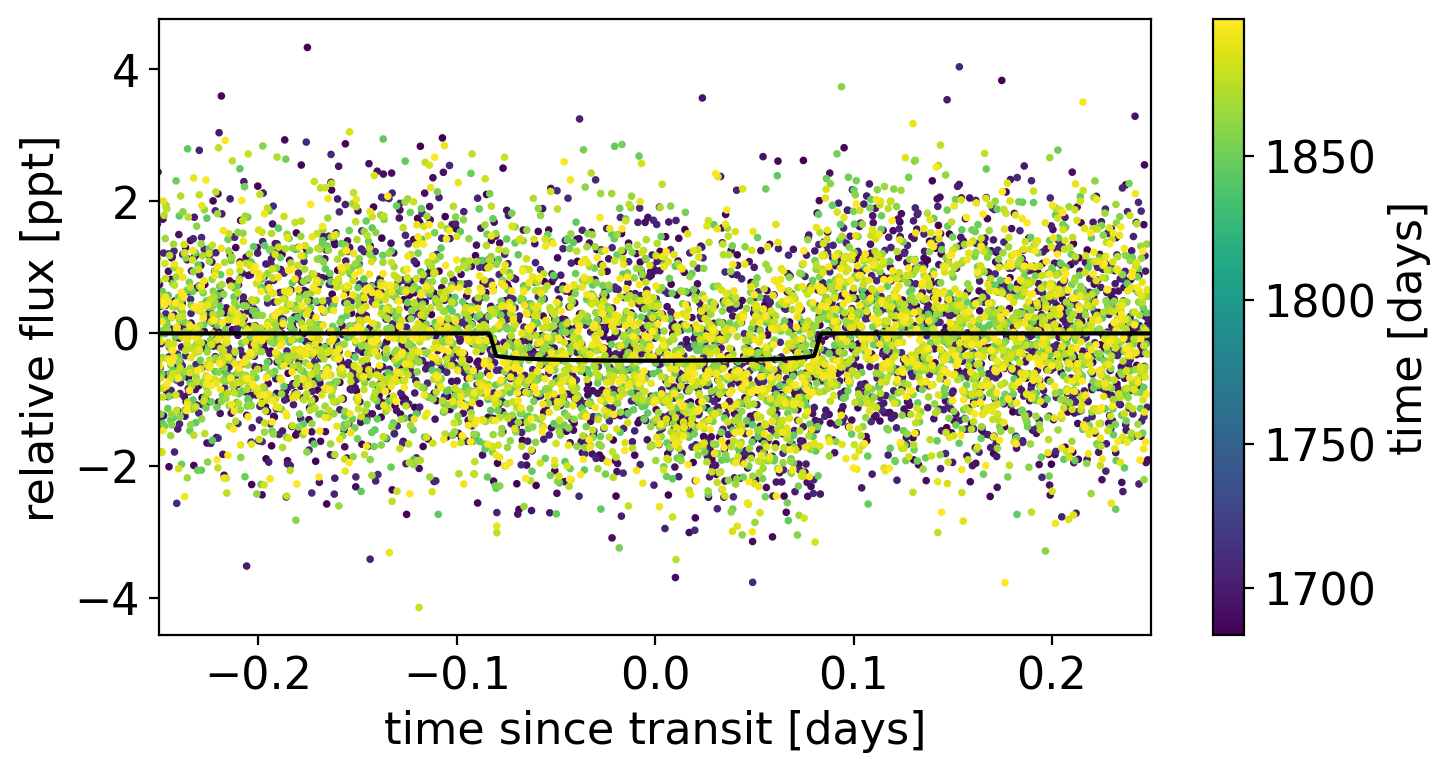

In [15]:
gp_pred, lc_pred = obtain_prediction(toi_model, gp, lc_model, map_soln)
plot_model(lc, toi_model, map_soln, gp_pred, lc_pred)

That looks better!

Now on to sampling:

In [16]:
TUNE = 200
DRAWS = 200
CHAINS = 1

np.random.seed(286923464)

def start_model_sampling(model):
    with model:
        trace = pm.sample(
            tune=TUNE,
            draws=DRAWS,
            start=map_soln,
            chains=CHAINS,
            step=xo.get_dense_nuts_step(target_accept=0.9)
        )
        return trace

In [17]:
trace = start_model_sampling(toi_model)


Only 200 samples in chain.


Sequential sampling (1 chains in 1 job)


NUTS: [b, log_dur, t0, log_period, log_ror, log_w0, log_Sw4, sigma, u, mean]


Sampling 1 chain for 200 tune and 200 draw iterations (200 + 200 draws total) took 528 seconds.


The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


Only one chain was sampled, this makes it impossible to run some convergence checks


Then we can take a look at the summary statistics:

In [18]:
pm.summary(trace)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean,0.027,0.036,-0.042,0.086,0.002,0.002,257.0,120.0,256.0,96.0,NaN
log_Sw4,2.396,1.663,-1.386,4.865,0.240,0.171,48.0,48.0,44.0,95.0,NaN
log_w0,1.581,0.558,0.271,2.462,0.082,0.060,47.0,44.0,44.0,73.0,NaN
log_ror,-3.602,0.050,-3.677,-3.500,0.007,0.005,55.0,55.0,54.0,135.0,NaN
log_period,1.237,0.000,1.237,1.237,0.000,0.000,143.0,143.0,142.0,81.0,NaN
t0,1683.615,0.002,1683.612,1683.618,0.000,0.000,150.0,149.0,147.0,95.0,NaN
log_dur,-2.547,0.031,-2.611,-2.495,0.004,0.003,69.0,69.0,48.0,102.0,NaN
u[0],0.244,0.131,0.035,0.484,0.031,0.022,18.0,18.0,19.0,79.0,NaN
u[1],0.277,0.163,-0.031,0.576,0.078,0.060,4.0,4.0,4.0,26.0,NaN
sigma,0.123,0.017,0.097,0.155,0.002,0.002,56.0,55.0,59.0,60.0,NaN


And plot the posterior covariances compared to the values from [Pepper et al. (2019)](https://arxiv.org/abs/1911.05150):

In [19]:
def plot_posteriors(trace):
    samples = pm.trace_to_dataframe(trace, varnames=["period", "ror", "b"])
    corner.corner(samples);

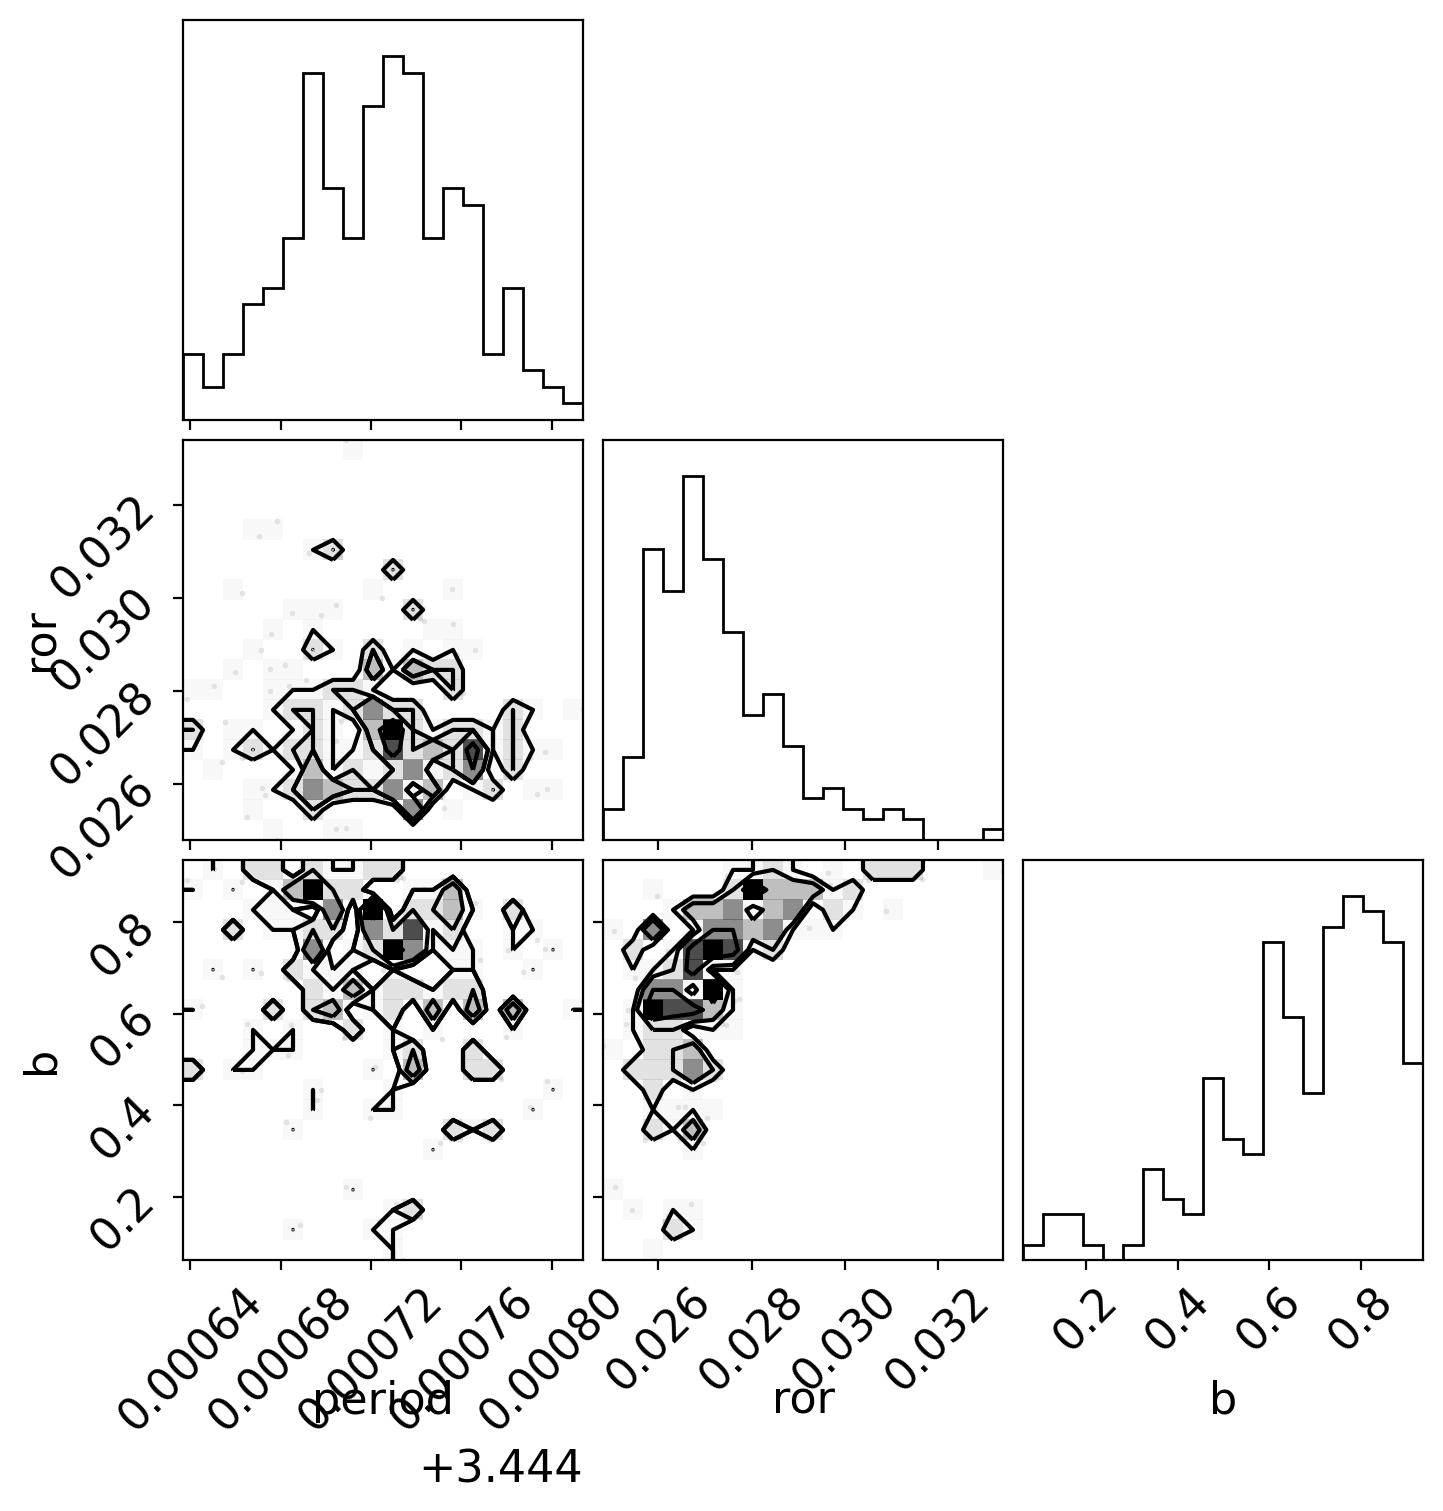

In [20]:
plot_posteriors(trace)

## Bonus: eccentricity

As discussed above, we fit this model assuming a circular orbit which speeds things up for a few reasons.
First, setting eccentricity to zero means that the orbital dynamics are much simpler and more computationally efficient, since we don't need to solve Kepler's equation numerically.
But this isn't actually the main effect!
Instead the bigger issues come from the fact that the degeneracies between eccentricity, arrgument of periasteron, impact parameter, and planet radius are hard for the sampler to handle, causing the sampler's performance to plummet.
In this case, by fitting with a circular orbit where duration is one of the parameters, everything is well behaved and the sampler runs faster.

But, in this case, the planet *is* actually on an eccentric orbit, so that assumption isn't justified.
It has been recognized by various researchers over the years (I first learned about this from [Bekki Dawson](https://arxiv.org/abs/1203.5537)) that, to first order, the eccentricity mainly just changes the transit duration.
The key realization is that this can be thought of as a change in the impled density of the star.
Therefore, if you fit the transit using stellar density (or duration, in this case) as one of the parameters (*note: you must have a* different *stellar density parameter for each planet if there are more than one*), you can use an independent measurement of the stellar density to infer the eccentricity of the orbit after the fact.
All the details are described in [Dawson & Johnson (2012)](https://arxiv.org/abs/1203.5537), but here's how you can do this here using the stellar density listed in the TESS input catalog:

In [21]:
def plot_reweighted_ecentricity_samples(toi, trace):
    star = Catalogs.query_object(f"TIC {toi.tic}", catalog="TIC", radius=0.001)
    tic_rho_star = float(star["rho"]), float(star["e_rho"])
    print("rho_star = {0} ± {1}".format(*tic_rho_star))

    # Extract the implied density from the fit
    rho_circ = np.repeat(trace["rho_circ"], 100)

    # Sample eccentricity and omega from their priors (the math might
    # be a little more subtle for more informative priors, but I leave
    # that as an exercise for the reader...)
    ecc = np.random.uniform(0, 1, len(rho_circ))
    omega = np.random.uniform(-np.pi, np.pi, len(rho_circ))

    # Compute the "g" parameter from Dawson & Johnson and what true
    # density that implies
    g = (1 + ecc * np.sin(omega)) / np.sqrt(1 - ecc ** 2)
    rho = rho_circ / g ** 3

    # Re-weight these samples to get weighted posterior samples
    log_weights = -0.5 * ((rho - tic_rho_star[0]) / tic_rho_star[1]) ** 2
    weights = np.exp(log_weights - np.max(log_weights))

    # Estimate the expected posterior quantiles
    q = corner.quantile(ecc, [0.16, 0.5, 0.84], weights=weights)
    print("eccentricity = {0:.2f} +{1[1]:.2f} -{1[0]:.2f}".format(q[1], np.diff(q)))

    corner.corner(
        np.vstack((ecc, omega)).T,
        weights=weights,
        plot_datapoints=False,
        labels=["eccentricity", "omega"],
    );

rho_star = 2.45081 ± 0.137379
eccentricity = 0.28 +0.31 -0.20


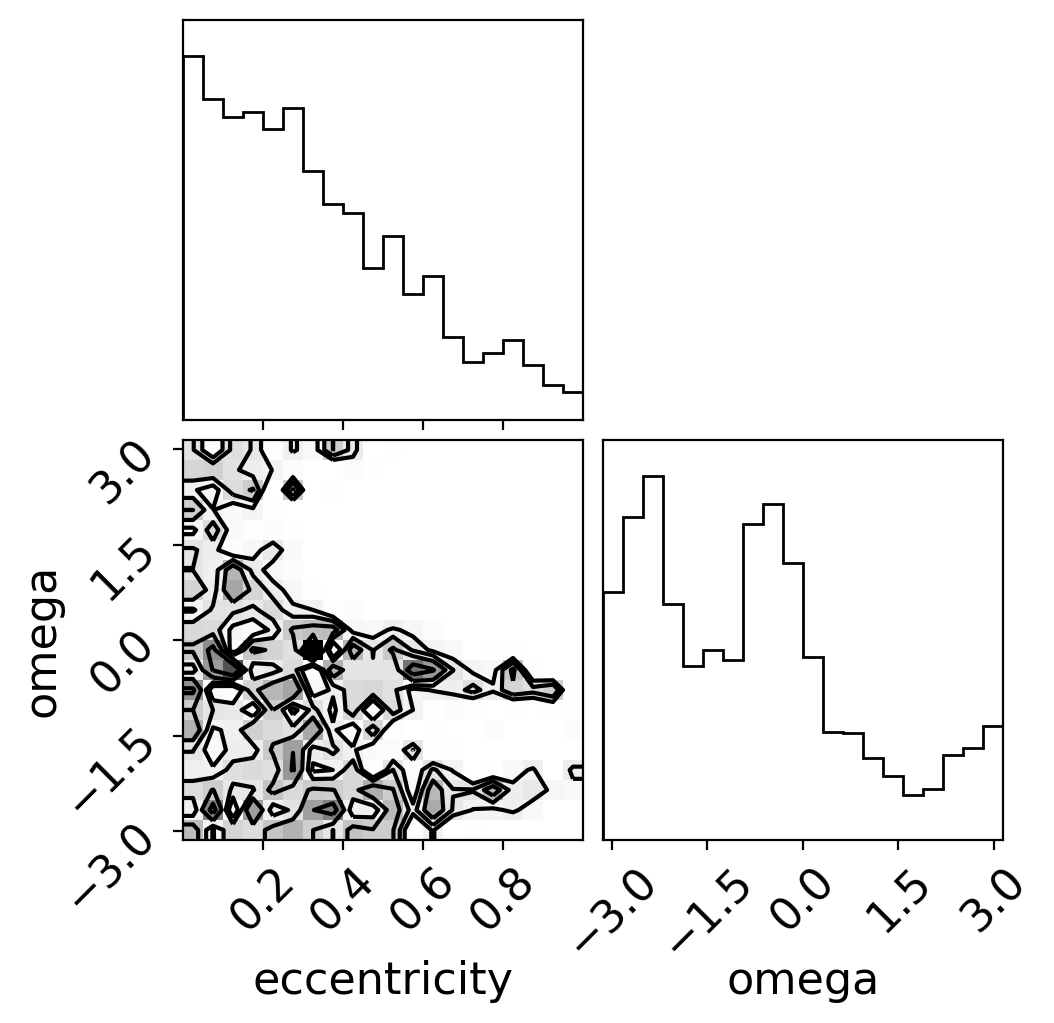

In [22]:
plot_reweighted_ecentricity_samples(toi, trace)

As you can see, this eccentricity estimate is consistent (albeit with large uncertainties) with the value that [Pepper et al. (2019)](https://arxiv.org/abs/1911.05150) measure using radial velocities and it is definitely clear that this planet is not on a circular orbit.

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [23]:
with toi_model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


print("\n".join(bib.splitlines()[:10]) + "\n...")

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [24]:
with toi_model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:agol19, exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [25]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Rodrigo Luger and Ian Czekala and
            Eric Agol and Adrian Price-Whelan and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.2},
   month = may,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
